In [327]:
# Import necessary libs
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [328]:
# Pre-define some hyperparameters
# Define iterations and batch size
n_iteration = 200
batch_size = 256

In [329]:
# Read in data file
df_all = pd.read_csv('../Processed Data/AllPlayerDataProcessed.csv')
df_gk = pd.read_csv('../Processed Data/GKDataProcessed.csv')
df_bk = pd.read_csv('../Processed Data/BKDataProcessed.csv')
df_md = pd.read_csv('../Processed Data/MDDataProcessed.csv')
df_fwd = pd.read_csv('../Processed Data/FWDDataProcessed.csv')

In [330]:
# Here we define the regression model class as follows
class RegressionNN(nn.Module):
    def __init__(self, inputSize):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(inputSize, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [331]:
# Transform data into tensor form
def Tensorize(df):
    target = df.Overall
    y = np.array(target, dtype = np.float32)
    df_model = df.drop(['Overall', 'Index'], axis = 1)
    X = np.array(df_model, dtype = np.float32)

    # Splitting data
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

    # Converting data to type torch
    X_train_tensor = torch.from_numpy(X_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_train_tensor = torch.from_numpy(y_train).float().reshape(y_train.shape[0], 1)
    y_val_tensor = torch.from_numpy(y_val).float().reshape(y_val.shape[0], 1)
    y_test_tensor = torch.from_numpy(y_test).float().reshape(y_test.shape[0], 1)

    # Calculating batch amount
    n_train_data = X_train.shape[0]
    n_batch = int(np.ceil(n_train_data/batch_size))
    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch

In [332]:
# Model training
def Train_Regression(model, optimizer, criterion, n_batch):
    for i in range(n_iteration):
        # Train with batch GD
        for j in range(n_batch):
            batch_start_index = j*batch_size
            X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
            y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]

            y_out = model(X_batch)
            loss = criterion(y_out, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [333]:
# Neural network to predict ratings for arbitrary players
# Data from all players
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch = Tensorize(df_all)

In [334]:
# Regression model for all data
regressor_all = RegressionNN(X_train_tensor.shape[1])
optimizer = optim.Adam(regressor_all.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

# Training
Train_Regression(regressor_all, optimizer, criterion, n_batch)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [335]:
# Testing
y_test_out = regressor_all(X_test_tensor)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test_tensor, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test_tensor, y_test_out.detach().numpy()))))

r2 score: 0.9844766283220941
RMSE : 0.88028324


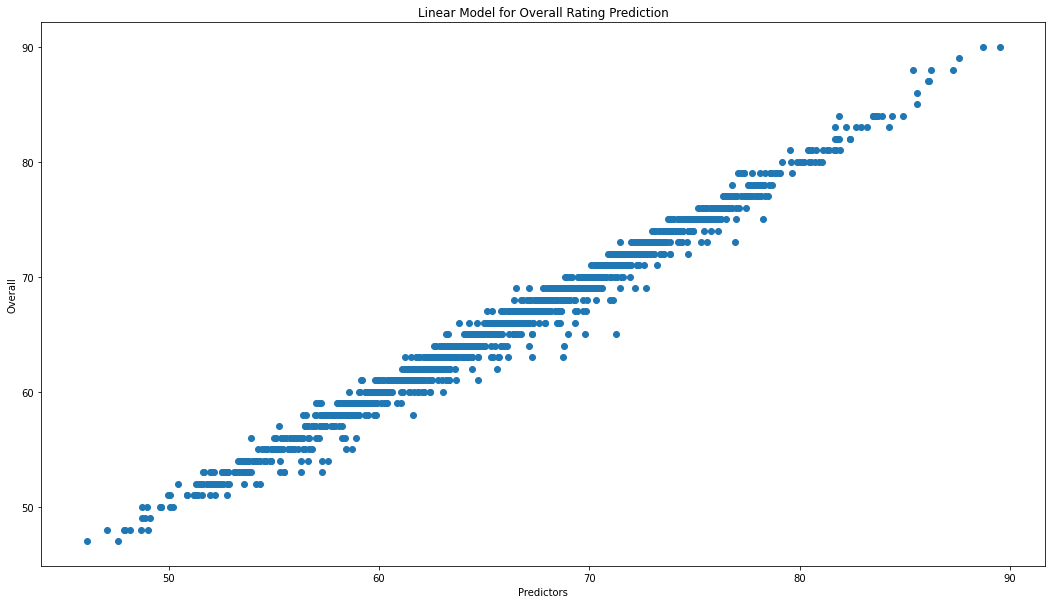

In [336]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test_tensor.numpy())
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Overall Rating Prediction")
plt.show()

In [337]:
# Neural network to predict ratings for goalkeepers
# Data from goalkeepers
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch = Tensorize(df_gk)

In [338]:
# Regression model for goalkeepers
regressor_gk = RegressionNN(X_train_tensor.shape[1])
optimizer = optim.Adam(regressor_gk.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

# Training
Train_Regression(regressor_gk, optimizer, criterion, n_batch)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [339]:
# Testing
y_test_out = regressor_all(X_test_tensor)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test_tensor, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test_tensor, y_test_out.detach().numpy()))))

r2 score: 0.9983820680639304
RMSE : 0.3230539


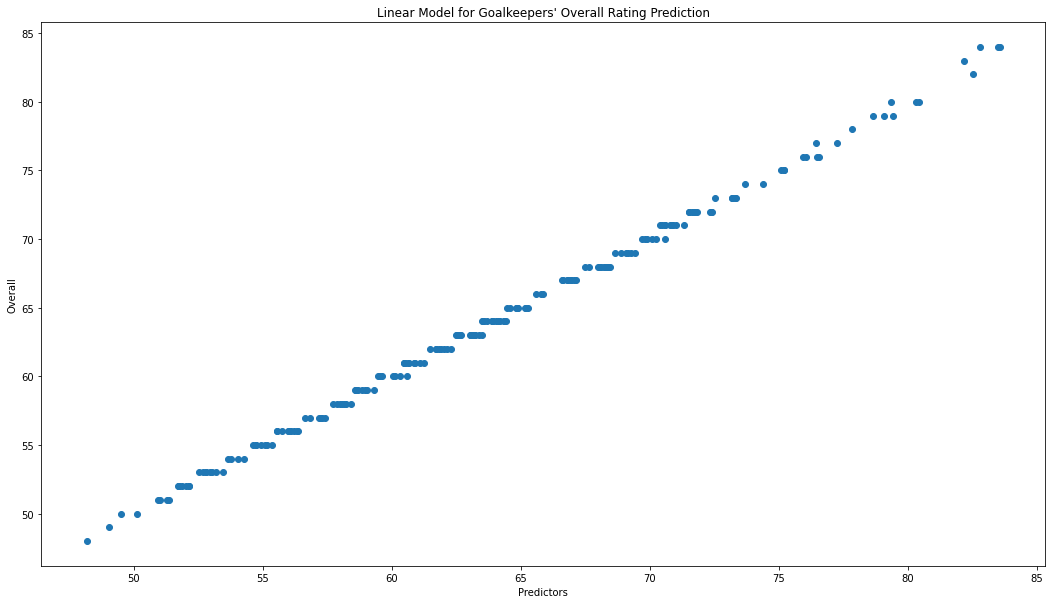

In [340]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test_tensor.numpy())
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Goalkeepers' Overall Rating Prediction")
plt.show()

In [341]:
# Neural network to predict ratings for backfielders
# Data from backfielders
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch = Tensorize(df_bk)

In [342]:
# Regression model for backfielders
regressor_bk = RegressionNN(X_train_tensor.shape[1])
optimizer = optim.Adam(regressor_bk.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

# Training
Train_Regression(regressor_bk, optimizer, criterion, n_batch)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [343]:
# Testing
y_test_out = regressor_all(X_test_tensor)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test_tensor, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test_tensor, y_test_out.detach().numpy()))))

r2 score: 0.98587874515482
RMSE : 0.77185845


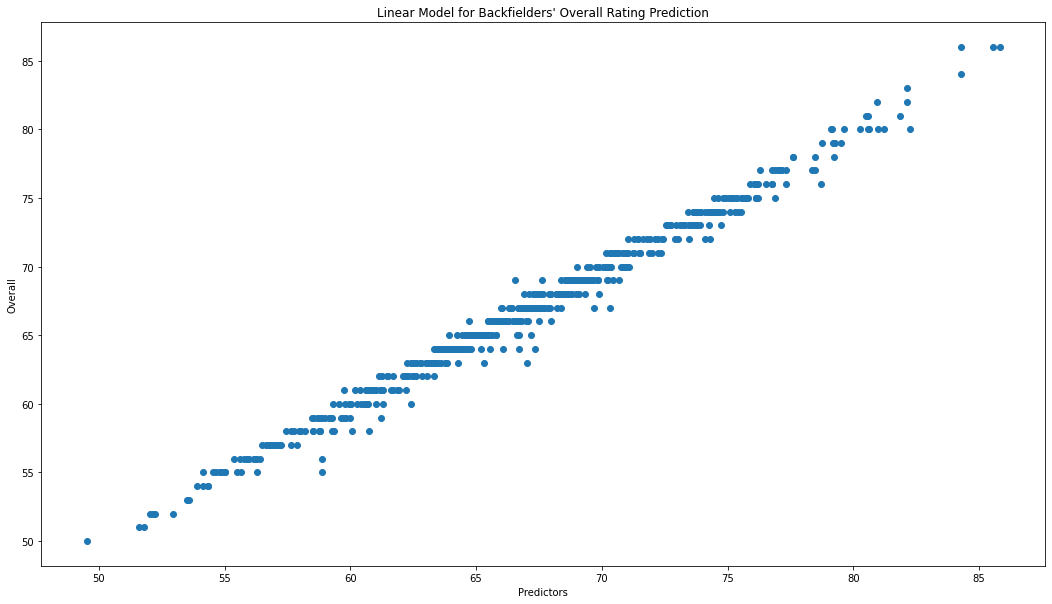

In [344]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test_tensor.numpy())
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Backfielders' Overall Rating Prediction")
plt.show()

In [345]:
# Neural network to predict ratings for midfielders
# Data from midfielders
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch = Tensorize(df_md)

In [346]:
# Regression model for midfielders
regressor_md = RegressionNN(X_train_tensor.shape[1])
optimizer = optim.Adam(regressor_md.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

# Training
Train_Regression(regressor_md, optimizer, criterion, n_batch)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [347]:
# Testing
y_test_out = regressor_all(X_test_tensor)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test_tensor, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test_tensor, y_test_out.detach().numpy()))))

r2 score: 0.9817492560309454
RMSE : 0.9547651


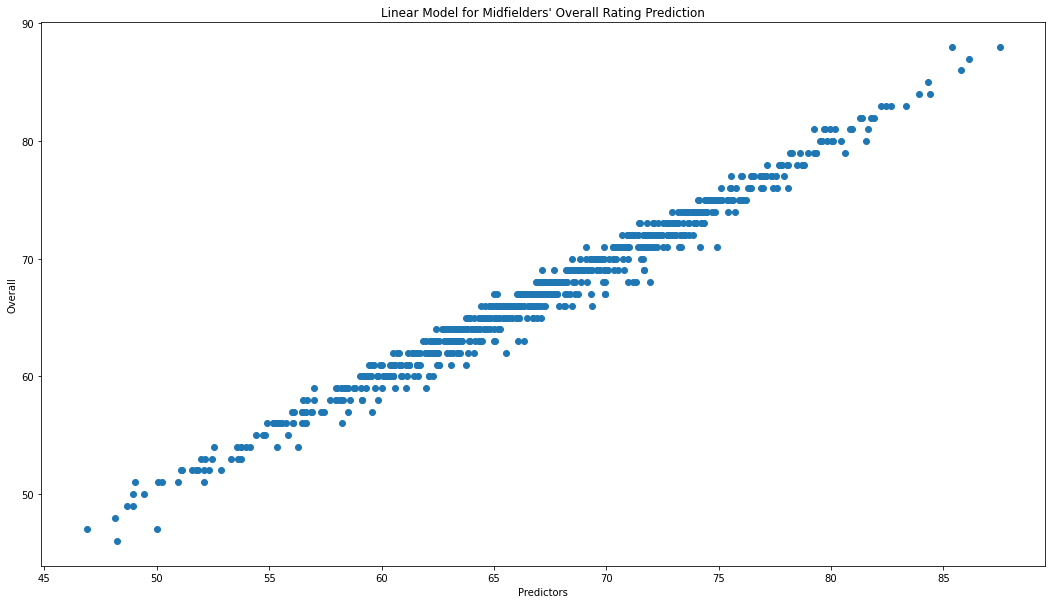

In [348]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test_tensor.numpy())
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Midfielders' Overall Rating Prediction")
plt.show()

In [349]:
# Neural network to predict ratings for strikers / forwards
# Data from strikers
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor, n_batch = Tensorize(df_fwd)

In [350]:
# Regression model for strikers
regressor_fwd = RegressionNN(X_train_tensor.shape[1])
optimizer = optim.Adam(regressor_fwd.parameters(), lr=1e-3)
criterion = nn.MSELoss(size_average=False)

# Training
Train_Regression(regressor_fwd, optimizer, criterion, n_batch)

C:\Users\lhc\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [351]:
# Testing
y_test_out = regressor_all(X_test_tensor)

#Finding the r2 score and root mean squared error
print('r2 score: '+str(r2_score(y_test_tensor, y_test_out.detach().numpy())))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test_tensor, y_test_out.detach().numpy()))))

r2 score: 0.9933358594607163
RMSE : 0.5965359


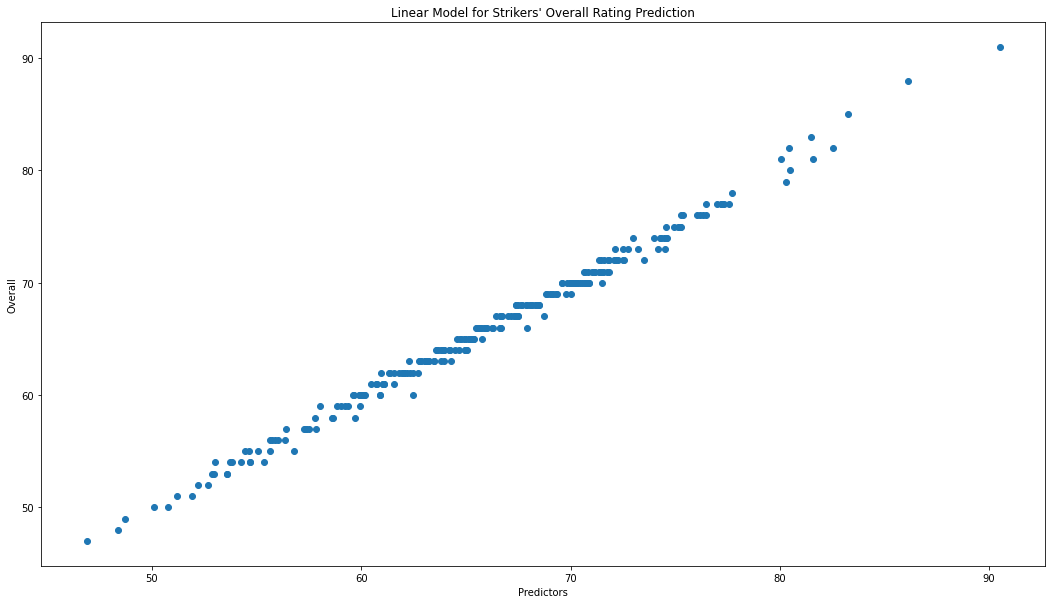

In [352]:
# Plot the results
plt.figure(figsize=(18,10))
plt.scatter(y_test_out.detach().numpy(), y_test_tensor.numpy())
plt.xlabel("Predictors")
plt.ylabel('Overall')
plt.title("Linear Model for Strikers' Overall Rating Prediction")
plt.show()